# Spatial model

**Open questions**
* When `age_stratified=False`, some important parameters (such as `h`) are not loaded (or at least that's what the function information says). This is wrong?
    * Pretty sure this is wrong and also sure this should be fixed
* Why are the matrices found by `polymod.get_interaction_matrices()` not identical to those found in the [SOCRATES](https://lwillem.shinyapps.io/socrates_rshiny/) tool? How is this tool to be interpreted? See [this](https://www.medrxiv.org/content/10.1101/2020.03.03.20030627v2) paper.
* When taking the parameter values with `get_COVID19_SEIRD_parameters(age_stratified=True)`, not all values are being copied from their age-stratified values. Examples:
    * Mortalities for patients in ICU *is* age-stratified
    * Average number of days in cohort when patient will recover *is not* age-stratified. Why not? Because there is not enough data available.
* Should we work with the most recent data where possible? E.g. for initial population, almost all arrondissements have higher population now than 9 years ago (2011 census), and this is easily found online.
* Why is the initial population per age in `polymod.get_interaction_matrices()[0]` significantly larger than the sum over all arrondissements in `../../data/interim/census_2011/initN.csv`? Which one should we use? Both are from roughly the same time period, no?
    * Compare e.g. `polymod.get_interaction_matrices()[0]` with `initN_df['[0,10['].sum()`
* In the relative susceptibility taken from the study of Davies, *all* $s$-values are below 1. I would expect the age-weighed average of $s$ to be precisely 1.
    * Why is this not the case?
    * Does that mean that we must not take `pars_dict['s'] = 1` in the case of no age stratification?
    * I have written down these concerns in a $\LaTeX$ document
* `pars_dict['Nc'] = np.array([11.2])` comes from the average number of contacts, weighed by age. The other matrices do *not* appear to be weighed by age. What do we want?
    * This is also updated to the correct value in SOCRATES (18 point something)
* The simulation sometimes runs into a division by zero (but generally continues running)
* What does the `.sim` attribute do? I cannot find this anywhere.
    * See `base.py`
* I do not understand how the `integrate` function defined in `models.py` is related to the rest of the code, and I also do not understand how `BaseModel` can be an argument of the class in `models.py`. Confusing.
    * Update: `integrate` is part of `base.py`. The search function only works for the part of the code you can see!
* Why, in `models.py`, is there a difference between `parameters_stratified_names` and `stratification`? Not very clear
    * One is used simply to sum up the stratified parameters. The second one does so too, but is also used to determine the dimensions all the stratifications are supposed to have. They are the mobility matrix and the overall contact matrix.
* Shouldn't `Nc` be symmetric? Right now it isn't, and this causes some ambiguity in the calculation of the probability of infection P
    * Tijs has made a lot of improvements on this since last meeting
* What are the classes `H_in`, `H_out` and `H_tot`?
    * These are parameters that do not belong to SEIR compartments, but are very useful to plot. Therefore they are calculated from the propensities in the end.
* If I take `1e20` (impossibly many) infected people, there is still only a chance of 20 percent that a baby will become exposed the next day. Is this logical? Is this perhaps what the normalisation establishes?
    * Probably T also goes up, so we just reach saturation.
* It appears that it is very important you reset the figure environment within the loop, otherwise information will keep on being added to the plot, which slows down the process really hard

**Open tasks**
* Go through the structure of all `data` and `src` modules, in particular `BaseModel`
* Adjust `get_COVID19_SEIRD_parameters` to take and return data needed for spatial extension
    * It would be nice to be able to *choose* the level of stratification
        * Age: take data straight from the full SOCRATES tool (probably not very convenient to implement)
        * Space: choose between *artificial*, *postal code*, municipality, arrondissement, province. Focus is on provinces, because this is what will be used in the FAGG
    * Adjust the function description (this is kind of a mess now)
* Find a way to *first* work *without* age stratification
    * Make a clear distinction between age-stratified case and non-stratified case
    * Make available all non-stratified data, and make sure this is correct: currently the average $m_0$ is set to 0.5, which seems terribly high
* Show scatter plot to demonstrate 'Matthew effect'
* Change the implementations in `models.py` into nice `matmul` methods
    * I have done quite the opposite: in its current implementation, it is very clear what is going on ("naive" Python), but it is not very elegant. Naturally, this does not have priority.
* Interpret the `Effective-infection-probability_arr.jpg` image. This does *not* look very realistic!
* Add `spatial='test'` as an option, which demonstrates only the arrondissements Brussel, Antwerpen and Gent and only takes into account an artificial mobility between these three
* Implement the possibility of making a model without age stratification but with spatial stratification
* Find an elegant way to choose the spatial stratification in `coordinates = [read_coordinates_nis(spatial='arr')]` in `models.py` **priority**
* Implement Age-stratification for mobility
    * Not urgent because there is no such data available yet
* fill up these missing values in the hospital data and update the existing values with newer data from new studies. If this does not exist, we may have to come back to the averages, but this is not very representative
* Find a way to co-animate the graph of the total number of hospitalisations

## Load packages

In [181]:
import random
import os
import numpy as np
import json
import corner # make beautiful corner plots for demonstrating the parameter distributions
import random
import os

import pandas as pd
import geopandas as gp
import datetime
import scipy
import matplotlib
import matplotlib.colors as colors
import matplotlib.dates as mdates # sophisticated date plotting capabilities
import math
import xarray as xr # labels in the form of dimensions, coordinates and attributes
import emcee # Goodman & Weare’s Affine Invariant Markov chain Monte Carlo (**MCMC**) Ensemble sampler
import matplotlib.pyplot as plt

from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.models.utils import name2nis, read_coordinates_nis, read_areas, read_pops, dens_dep # New function that translates names to NIS codes
from covid19model.data import google, sciensano, model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Understand current code and data loads

### `COVID19_SEIRD_sto_spatial`

The class `COVID19_SEIRD_sto_spatial` inside `models.py` in which the integration happens, takes the same inputs as `BaseModel`. This is:
1. `states`: dictionary of initial states of all (stratified) compartments. Typically, only the compartments S, E and T (total) are non-zero at the start. The states are matrices with dimensions of the stratification (e.g. 3x4)
2. `parameters`: dictionary of parameters (both stratified and not) that are obtained with `parameters.get_COVID19_SEIRD_parameters()`
3. `compliance`. Set to `None` by default, but we will generally use `ramp_2`
4. `discrete`. Set to `False` by default, but we implement a discrete set now (i.e. `True`)

In [119]:
# When spatial==True, the mobility matrix is added to the parameter dictionary:
# This is only the 43x43 matrix, and contains the old definitions of arrondissements (does not have 58000 yet)
# Read as: fraction of (row) commutes to (column), so the sum of every row should be unity

mobility_df=pd.read_csv('../../data/interim/census_2011/census-2011-updated_row-commutes-to-column_arrondissements.csv', index_col=['NIS'])
NIS=mobility_df.values.astype(float)
# Normalize recurrent mobility matrix
for i in range(NIS.shape[0]):
    NIS[i,:]=NIS[i,:]/sum(NIS[i,:])
NIS

FileNotFoundError: [Errno 2] No such file or directory: '../../data/interim/census_2011/census-2011-updated_row-commutes-to-column_arrondissements.csv'

In [ ]:
# Every arrondissement has an initial population (initial number of susceptibles) per age group

# Read CSV as dataframe with the first column (NIS) as index
NIS = read_coordinates_nis(name='arrond')

# Save the population distribution for all arrondissements
NIS

# Make sure the shape of the initN is 1x43 rather than just 43
# N_dummy = []
# for i in range(len(initN)):
#     N_dummy.append([initN[i]])
    
# initN = np.asarray(N_dummy)

### `get_COVID19_SEIRD_parameters`

The Python code `data/model_parameters.py` contains the important (and only) function `get_COVID19_SEIRD_parameters` which fetches all necessary parameters. Information (note that this is quite a mess):
* Takes two inputs
    * `stratified`: Boolean, choose whether or not there is age stratification
    * `spatial`: Boolean, choose whether or not there is spatial stratification
* Returns the parameter dictionary, as desired as input to `COVID19_SEIRD_sto_spatial(BaseModel)`
* If both `stratified` and `spatial` are true, the parameters are ...
    * `beta` : probability $\beta$ of infection when encountering an infected person
    * `sigma` : length $\sigma$ of the latent period
    * `omega` : length $\omega$ of the pre-symptomatic infectious period
    * `zeta`: effect $\zeta$ of re-susceptibility and seasonality
    * `a` : probability $a$ of an asymptomatic cases
    * `m` : probability $m$ of an initially mild infection (m=1-a): superfluous
    * `da` : duration $d_a$ of the infection in case of asymptomatic
    * `dm` : duration $d_m$ of the infection in case of mild
    * `der` : duration of stay $d_{\text{ER}}$ in emergency room/buffer ward
    * `dc` : average length $d_c$ of a hospital stay when not in ICU
    * `dICU_R` : average length $d_{\text{ICU},R}$ of a hospital stay in ICU in case of recovery
    * `dICU_D`: average length $d_{\text{ICU},D}$ of a hospital stay in ICU in case of death
    * `dhospital` : time $d_\text{hosp}$ before a patient reaches the hospital (*below: age-stratified*)
    * `s`: relative susceptibilities $s_i$ to infection (unique)
    * `a` : probabilities $a_i$ of an asymptomatic case (overwrites $a$ and $m$)
    * `h` : probabilities $h_i$ of hospitalisation for a mild infection
    * `c` : probabilities $c_i$ of hospitalisation in Cohort (non-ICU)
    * `m_C` : mortalities $m_{C,i}$ in Cohort
    * `m_ICU` : mortalities $m_{\text{ICU},i}$ in ICU (*below: spatially stratified*)
    * `NIS`: normalised mobility between NIS codes
* If no age stratification is chosen, the final value in the data column always communicates the weighted average

In [ ]:
# Most hospital data is taken from `data/interim/model_parameters/AZMM_UZG_hospital_parameters.csv`,
# which is good but may be updated with Sciensano data at some point.
# Question: why is m_C age-stratified ([:-1]) and e.g. dC_R not ([-1])?

# This hospital data looks as follows
df = pd.read_csv('../../data/interim/model_parameters/AZMM_UZG_hospital_parameters.csv', sep=',',header='infer')
df = df.fillna(0)
print(df)

m_ICU = np.array(df['m0_{ICU}'].values[:-1])
dc_R = np.array(df['dC_R'].values[-1])

print(m_ICU)
print(dc_R)

df

In [ ]:
# Some additional data is taken from `verity_etal.csv` and `davies_etal.csv` in the raw directory
# full Verity data
df = pd.read_csv('../../data/raw/model_parameters/verity_etal.csv', sep=',',header='infer')
print(df)

# h: probability of being hospitalised per age
h = np.array(df.loc[:,'symptomatic_hospitalized'].astype(float).tolist())/100
print(h)

In [ ]:
# full Davies data
df_asymp = pd.read_csv('../../data/raw/model_parameters/davies_etal.csv', sep=',',header='infer')
print(df_asymp)

# a: probabilty of being asymptomatic per age; s: relative susceptibility per age
a = np.array(df_asymp.loc[:,'fraction asymptomatic'].astype(float).tolist())
s = np.array(df_asymp.loc[:,'relative susceptibility'].astype(float).tolist())
print(a)
print(s)

In [ ]:
# If there is no age stratification (as we may want to try at first in the simplified spatial model),
# the parameter dictionary takes parameter values from `../../data/raw/model_parameters/non_stratified.csv`
# and updates the parameters dictionary with these

non_strat = pd.read_csv("../../data/raw/model_parameters/non_stratified.csv", sep=',',header='infer')
a = non_strat['a'].values[0]
a
non_strat
# pars_dict.update({key: np.array(value) for key, value in non_strat.to_dict(orient='list').items()})

In [ ]:
# Beta is set manually
beta = 0.03492
beta

In [ ]:
# Remaining parameters

df_other_pars = pd.read_csv('../../data/raw/model_parameters/others.csv', sep=',',header='infer')
df_other_pars

### `polymod.get_interaction_matrices`

This function returns the total number of individuals in ten year age bins in the Belgian population and the interaction matrices Nc at home, at work, in schools, on public transport, during leisure activities and during other activities. This is eventually linked to Lander Willem's SOCRATES tool, saved as `txt` files in `../../data/raw/polymod/interaction_matrices/Belgium/`.

Returns ...
1. `initN` : np.array : number of Belgian individuals, regardless of sex, in ten year age bins. **`initN[0]` refers to the youngest (0-10 years)**
2. `Nc_home` :  np.array (9x9) : number of daily contacts at home of individuals in age group X with individuals in age group Y
3. `Nc_work` :  np.array (9x9) : number of daily contacts in the workplace of individuals in age group X with individuals in age group Y
4. `Nc_schools` :  np.array (9x9) : number of daily contacts in schools of individuals in age group X with individuals in age group Y
5. `Nc_transport` :  np.array (9x9) : number of daily contacts on public transport of individuals in age group X with individuals in age group Y
6. `Nc_leisure` :  np.array (9x9) : number of daily contacts during leisure activities of individuals in age group X with individuals in age group Y
7. `Nc_others` :  np.array (9x9) : number of daily contacts in other places of individuals in age group X with individuals in age group Y
8. `Nc_total` :  np.array (9x9) : total number of daily contacts of individuals in age group X with individuals in age group Y, calculated as the sum of all the above interaction. **`Nc_total[i][j]` is the number of visits that agent in age group `i` brings to agent in age group `j`**

If no age stratification is chosen, `initN` is the total Belgian population, and `Nc_total` is the average number of contacts per day, fixed at 11.2.

In [ ]:
# Interaction matrix is taken from the Polymod study
# Assign Nc_total from the Polymod study to the parameters dictionary
# NOTE how this does not correspond to the data on the SOCRATES tool website.
Nc_schools = polymod.get_interaction_matrices()[3]
pd.DataFrame(Nc_schools)

pd.DataFrame(polymod.get_interaction_matrices()[1])

## Initialise and execute model

### Messing around with new `time_dependent_parameters` implementation

In [ ]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()
levels = initN.size

# ramp_2 with new time_dependent_parameters definitions
# param currently unused
def social_policy_func(t,param,policy_time,policy1,policy2,l,tau):
    if t < policy_time:
        return policy1
    else:
        return policy1 + (1/l)*(t-policy_time)*(policy2-policy1)
    
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

# Add the delayed ramp parameters and the social_policy_func parameters to the parameter dictionary.
params.update({'l': 1,
              'tau': 5})
params.update({'policy1': Nc_total, # No restrictions
          'policy2': Nc_home, # Everyone in home isolation
          'policy_time': 40})

# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}


# Initialize the model
model = models.COVID19_SEIRD_sto(initial_states, params, time_dependent_parameters={'Nc': social_policy_func})

### Define initial states and (compliance) parameters

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`
params = model_parameters.get_COVID19_SEIRD_parameters(age_stratified=True, spatial=True)

def social_policy_func(t,param,policy_time,policy1,policy2,l,tau):
    if t < policy_time:
        return policy1
    else:
        return policy1 + (1/l)*(t-policy_time)*(policy2-policy1)
    
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

# Add the delayed ramp parameters and the social_policy_func parameters to the parameter dictionary.
params.update({'l': 1,
              'tau': 5})
params.update({'policy1': Nc_total, # No restrictions
          'policy2': Nc_home, # Everyone in home isolation
          'policy_time': 40})

# Define a cluster of 20 infectees in one or two arrondissements

# Define an empty matrix with the dimensions of an exposed age-stratified population per arrondissement (1x43)
E = np.zeros(initN.shape)

print(initN)

# If the index value in the initN dataframe corresponds to the NIS code of (arrondissement), fill the entire row with (value)
# `numpy.where(condition[, x, y])`: Return elements chosen from x or y depending on condition.
E[np.where(NIS==name2nis('arrondissement ieper'))[0][0]] = 20 
E[np.where(NIS==name2nis('arrondissement tongeren'))[0][0]] = 20

# Define the initial condition: two exposed inidividual in every age category of two arrondissements
# The rest of the categories are empty by default
initial_states = {'S': initN, 'E': E}

# Load the compliance model (we use ramp_2, which I guess is the time-delayed ramp)
from covid19model.models.compliance import ramp_2

# Initialize the discrete model with ramp_2 compliance, parameters for the spatial case, and initial conditions (S and E population)
model = models.COVID19_SEIRD_sto(initial_states, params, time_dependent_parameters=ramp_2, discrete=True)

In [ ]:
params

In [ ]:
# Change beta value
# Original value is 0.03492
model.parameters['beta'] = 0.5
params = model.parameters
params

### Define a checkpoints dictionary and perform some simulations

* A checkpoint is part of the original McGee code, where a policy change can be implemented. In this case: a policy change at the 20th of April 2020, where the interaction is altered: 0.3 * home interaction, 0.09 * work interaction, 0.12 * transportation interaction.
* Check `model.sim?` for information on the simulation. The default starting date is 2020-03-15. Runs till September 21st
* *Question*: what does `excess_time` mean, and how should I read the plot? Not sure what I'm looking at.
* *Question* The results differ (more than) an *order of magnitude* in peak value. That's huge! Are these results at all useful? Note how the measures efficiently bring $R_0$ down under 1, causing new infections to die out fast.
* *Question*: Why does the `out` dataset have a time dimension of 241? I thought the model only runs between 15 March and 21 September.
* `NIS` dimension has been changed to `place` dimension (name change)

* Also interesting (and expected): if we introduce more initial cases, chances of the infection dying out by chance are very slim, so the resulting time series will be more similar.
* *Question*: where do the fluctuations on a single line come from? The only parameter change happens at 20 april.

In [ ]:
# Age-stratified
Ninit_dummy, Nc_home, Nc_work, Nc_school, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()

# Not age-stratified
# # this sums to 11.25
# Nc_home = 3.21
# Nc_work = 2.05
# Nc_school = 0.95
# Nc_transport = 0.41
# Nc_leisure = 2.3
# Nc_others = 2.33

chk = {
    'time': ['20-04-2020'],
    'Nc':   [0.3*(1.0*Nc_home + 0.3*Nc_work + 0.4*Nc_transport)]
}


# out

In [ ]:
# Note: this is computationally expensive

# Run the model 20 times, sum over all age classes and arrondissements, show the new hospitalisations
fig,ax=plt.subplots()
for i in range(2):
    out=model.sim('21-09-2020',excess_time=50,checkpoints=chk)
    # Select this one for the sum of all NIS codes
    #sumNIS=out.sum(dim="place").sum(dim="Nc")
    # Select this one for only NIS==21000
    sumNIS=out.sel(place=21000).sum(dim='Nc')
    plt.plot(out["time"].values,sumNIS["H_in"].values,alpha=0.5,color='green')

## Visualisation on a map

### Read the arrondissements shape file

In [ ]:
# Load different geographical aggregations
country = gp.read_file("../../data/raw/geopandas/BE/AD_6_Country.shp") # 1 entry
regions = gp.read_file("../../data/raw/geopandas/BE/AD_5_Region.shp") # 3 entries
provinces = gp.read_file("../../data/raw/geopandas/BE/AD_4_Province.shp") # 11 entries
arrondissements = gp.read_file("../../data/raw/geopandas/BE/AD_3_District.shp") # 43 entries
municipalities = gp.read_file("../../data/raw/geopandas/BE/AD_2_Municipality.shp") # 581 entries

municipalities

### Perform a single simulation

#### Comments Michiel
* Again note that different simulations give *very* different results (more than order of magnitude difference)! Run code below a couple of time to see this.
* The plot below shows whether the pandemic was 'serious': it shows whether it is worth making a gif from
* In images the cumulative data is shown. In the plot below as well.
* The statement `out.sum(dim="Nc")['M'][:,day]` can be made more efficient with cumsumNIS_M (but not really necessary)
* x100 in `data2plot` because we want to show the percentage
* `norm=colors.LogNorm`: Normalize a given value to the 0-1 range on a log scale.
* I'm not sure what the difference is between the first frame and the other frames (legend on/off?)
* 

In [ ]:
# simulation for 250 days (after March 15th) with the measure changes defined above
out=model.sim(250,checkpoints=chk)

# Again sum over all ages and arrondissements, and show people that are mildly affected on a national level
sumNIS=out.sum(dim="place").sum(dim="Nc")
cumsumNIS_M = np.cumsum(sumNIS["M"]) # sumNIS["M"]
plt.plot(out["time"], cumsumNIS_M, alpha=0.5, color='green')

In [ ]:
output_path = 'results/maps'

# create the plot
fig, ax = plt.subplots(figsize = (12,12)) # 12 inches x 12 inches

start = 0

# Create daily images for a .gif
for day in range(start,len(out['time'].values)):
    # Get data
    # Sum over age classes (not interested in those yet) and show the percentage of mildly symptomatic people
    data2plot = out.sum(dim="Nc")['M'][:,day].values / initN_df['total'].values*100
    
    # Make new 'data' column with the cumulative mildly symptomatic people that is updated every iteration
    arrondissementen['data'] = data2plot
    
    # Visualize data
    # Only produce a legend in the first frame?
    if day == start:
        fig = arrondissementen.plot(column = 'data', ax=ax, cmap='plasma',
                                    norm=colors.LogNorm(vmin=0.001, vmax=1), legend=True, edgecolor = 'k')
    else:
        fig = arrondissementen.plot(column = 'data', ax=ax, cmap='plasma',
                                    norm=colors.LogNorm(vmin=0.001, vmax=1), legend=False, edgecolor = 'k')
    # Disable axis
    ax.set_axis_off()
    # This will save the figure as a high-res png in the output path. You can also save as svg if you prefer.
    chart = fig.get_figure()
    #chart.savefig(output_path + str(day) + '_B.jpg' ,dpi=100)
    
    plt.close()

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(16, 4)
ax.plot(out['time'][50:200],out.sel(place=name2nis('arrondissement antwerpen')).sum(dim='Nc')['M'][50:200],color='blue',alpha=0.40)
ax.plot(out['time'][50:200],out.sel(place=name2nis('arrondissement La Louvière')).sum(dim='Nc')['M'][50:200],color='red',alpha=0.40)
ax.plot(out['time'][50:200],out.sel(place=name2nis('arrondissement luik')).sum(dim='Nc')['M'][50:200],color='black',alpha=0.40)
ax.legend(['Antwerp','Brussels','Luik'])
ax.axvline(130,color='black',linestyle='dashed')
ax.set_title('Daily hospitalizations $(H_{in})$')
fig.savefig('daily_hosp.jpg',dpi=300)

## Experimentations

In [226]:
# Below is the implementation for age_stratified=False

params = model_parameters.get_COVID19_SEIRD_parameters(age_stratified=False, spatial='test')
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(intensity=intensity, spatial='test')
N = len(params['Nc'])
G = len(params['place'][0])

params

# Set initial states
E = np.zeros([G,N])
S = np.zeros([G,N])
for g in range(G):
    S[g,0] = initN.sum(axis=1)[g]
print(S)
# Een groep mensen uit China landt in Zaventem
E[1,0] = 20
initial_states = {'S': S, 'E': E}

print(E)

# Add the delayed ramp parameters and the social_policy_func parameters to the parameter dictionary.
params.update({'ll': 5,
              'tau': 5})
params.update({'policy1': Nc_total, # No restrictions
          'policy2': Nc_home, # Everyone in home isolation
          'policy_time': 40})

model = models.COVID19_SEIRD_sto_spatial(initial_states, params, time_dependent_parameters={'Nc' : social_policy_func},
                                         discrete=True)

[[1057736.]
 [1218255.]
 [ 564042.]]
[[ 0.]
 [20.]
 [ 0.]]


In [37]:
mobility_data = '../../data/interim/census_2011/census-2011-updated_row-commutes-to-column_arr.csv'
mobility_df=pd.read_csv(mobility_data, index_col='NIS')

for nis in [11000, 21000, 44000]:
    value = 0
    for col in mobility_df.columns:
        if not col in ['11000', '21000', '44000']:
            value += mobility_df.loc[nis, col]
            mobility_df.loc[nis,col] = 0
    mobility_df.loc[nis, str(nis)] += value
    
# mobility_df.loc[[11000, 21000, 44000],['11000', '21000', '44000']].to_csv('census-2011-updated_row-commutes-to-column_test.csv')

In [94]:
# Load SEIRD parameters and polymod parameters
spatial = 'test'
intensity = 'all'

params = model_parameters.get_COVID19_SEIRD_parameters(age_stratified=True, spatial=spatial)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(intensity=intensity, spatial=spatial)

# Set initial states
E = np.zeros(initN.shape)
# Een groep dertigjarigen uit China landt in Zaventem
E[1,3] = 20
initial_states = {'S': initN, 'E': E}

# Add the delayed ramp parameters and the social_policy_func parameters to the parameter dictionary.
params.update({'ll': 5,
              'tau': 5})
params.update({'policy1': Nc_total, # No restrictions
          'policy2': Nc_home, # Everyone in home isolation
          'policy_time': 40})

# Close down all traffic
# params.update({'pi' : np.zeros(9)})


# Define the social policy function
def social_policy_func(t,param,policy_time,policy1,policy2,ll,tau):
    if t < policy_time:
        return policy1
    else:
        tt = t-policy_time
        if tt <= tau:
            return policy1
        if (tt > tau) & (tt <= tau + ll):
            intermediate = (policy2 - policy1) / ll * (tt - tau) + policy1
            return intermediate
        if tt > tau + ll:
            return policy2
    
# Load the model
model = models.COVID19_SEIRD_sto_spatial(initial_states, params, time_dependent_parameters={'Nc' : social_policy_func},
                                         discrete=True)

# Shows parameters that are loaded into the model
model.parameters

# Shows parameters that will change over time due to policies
model.time_dependent_parameters

model.parameters

{'beta': 0.03492,
 'sigma': 3.2,
 'omega': 2.0,
 'zeta': 0.0,
 'da': 7.0,
 'dm': 7.0,
 'der': 2.8,
 'dhospital': 7.5,
 'dc_R': array(8.01029195),
 'dc_D': array(6.11322507),
 'dICU_R': array(9.86672215),
 'dICU_D': array(19.33903233),
 'dICUrec': array(6.47233499),
 'area': array([1004.12540454,  162.41985043,  949.67394741]),
 'sg': array([2.3, 2.3, 2.3]),
 's': array([0.4 , 0.38, 0.79, 0.86, 0.8 , 0.82, 0.88, 0.74, 0.74]),
 'a': array([0.71, 0.79, 0.73, 0.67, 0.6 , 0.51, 0.37, 0.31, 0.31]),
 'h': array([0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.243, 0.273]),
 'c': array([1.        , 1.        , 0.8       , 0.875     , 0.78125   ,
        0.74193548, 0.61290323, 0.64285714, 0.88235294]),
 'm_C': array([0.        , 0.        , 0.        , 0.        , 0.08      ,
        0.02173913, 0.        , 0.17777778, 0.36666667]),
 'm_ICU': array([0.        , 0.        , 0.        , 0.        , 0.14285714,
        0.0625    , 0.16666667, 0.44      , 0.58333333]),
 'pi': array([1., 1., 1.,

In [95]:
from mpl_toolkits.axes_grid1 import make_axes_locatable # for plot aesthetics

# Load different geographical aggregations
maps_dir = '../../data/raw/geopandas/BE/'

country = gp.read_file(os.path.join(maps_dir, 'AD_6_Country.shp'))
regions = gp.read_file(os.path.join(maps_dir, 'AD_5_Region.shp'))
provinces = gp.read_file(os.path.join(maps_dir, 'AD_4_Province.shp'))
arrondissements = gp.read_file(os.path.join(maps_dir, 'AD_3_District.shp'))
municipalities = gp.read_file(os.path.join(maps_dir, 'AD_2_Municipality.shp'))
testgeo = arrondissements.loc[arrondissements['NISCode'].isin(['11000', '21000', '44000'])]

# Add NIS-code to Arrondissement Brussel-Hoofdstad
provinces.loc[provinces['NISCode']=='NA', 'NISCode'] = '21000'

In [96]:
out = model.sim(100)

In [180]:
dpi=100

E0 = out['E'].sum(axis=1).values[0,:]
E1 = out['E'].sum(axis=1).values[1,:]
E2 = out['E'].sum(axis=1).values[2,:]
tlist = out['time'].values
NISlist = out['place'].values

Edict = dict({11000 : E0, 21000 : E1, 44000 : E2})

vmin = 1
vmax = max(E1)

test['E'] = 0
for t in tlist:
    print('Working on day ', t)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    cax = make_axes_locatable(ax1).append_axes("left", size="5%", pad=1) # Legend properties
    ax1.set_axis_off()
    ax2.grid(False)
#     ax2.set_yscale('symlog')
    
    for key in Edict:
        test.loc[test['NISCode']==str(key), 'E'] = Edict[key][t]

    fig = test.plot(column='E', ax=ax1, cmap='Reds',
             legend=True, edgecolor = 'k', norm=colors.LogNorm(vmin=vmin, vmax=vmax), cax=cax, alpha=1)

    ax2.plot(tlist,E0,label='Antwerpen',color='r')
    ax2.plot(tlist,E1,label='Brussel-Hoofdstad',color='g')
    ax2.plot(tlist,E2,label='Gent',color='b')
    ax2.axvline(t, color='r', linewidth=2, linestyle='--')
    ax2.legend()
    
    # Save figure
    chart = fig.get_figure()
    figname = 'Spatial-simulation_H-in_20-30yo-21000_test' + str(t) + '.jpg'
    chart.savefig(figname, dpi=dpi, bbox_inches='tight')
    print('Saved figure ' + figname)
    
    plt.close('all')

Working on day  0
Saved figure Spatial-simulation_H-in_20-30yo-21000_test0.jpg
Working on day  1
Saved figure Spatial-simulation_H-in_20-30yo-21000_test1.jpg
Working on day  2
Saved figure Spatial-simulation_H-in_20-30yo-21000_test2.jpg
Working on day  3
Saved figure Spatial-simulation_H-in_20-30yo-21000_test3.jpg
Working on day  4
Saved figure Spatial-simulation_H-in_20-30yo-21000_test4.jpg
Working on day  5
Saved figure Spatial-simulation_H-in_20-30yo-21000_test5.jpg
Working on day  6
Saved figure Spatial-simulation_H-in_20-30yo-21000_test6.jpg
Working on day  7
Saved figure Spatial-simulation_H-in_20-30yo-21000_test7.jpg
Working on day  8
Saved figure Spatial-simulation_H-in_20-30yo-21000_test8.jpg
Working on day  9
Saved figure Spatial-simulation_H-in_20-30yo-21000_test9.jpg
Working on day  10
Saved figure Spatial-simulation_H-in_20-30yo-21000_test10.jpg
Working on day  11
Saved figure Spatial-simulation_H-in_20-30yo-21000_test11.jpg
Working on day  12
Saved figure Spatial-simulati

Saved figure Spatial-simulation_H-in_20-30yo-21000_test101.jpg
Working on day  102
Saved figure Spatial-simulation_H-in_20-30yo-21000_test102.jpg
Working on day  103
Saved figure Spatial-simulation_H-in_20-30yo-21000_test103.jpg
Working on day  104
Saved figure Spatial-simulation_H-in_20-30yo-21000_test104.jpg
Working on day  105
Saved figure Spatial-simulation_H-in_20-30yo-21000_test105.jpg
Working on day  106
Saved figure Spatial-simulation_H-in_20-30yo-21000_test106.jpg
Working on day  107
Saved figure Spatial-simulation_H-in_20-30yo-21000_test107.jpg
Working on day  108
Saved figure Spatial-simulation_H-in_20-30yo-21000_test108.jpg
Working on day  109
Saved figure Spatial-simulation_H-in_20-30yo-21000_test109.jpg
Working on day  110
Saved figure Spatial-simulation_H-in_20-30yo-21000_test110.jpg
Working on day  111
Saved figure Spatial-simulation_H-in_20-30yo-21000_test111.jpg
Working on day  112
Saved figure Spatial-simulation_H-in_20-30yo-21000_test112.jpg
Working on day  113
Save

Saved figure Spatial-simulation_H-in_20-30yo-21000_test199.jpg
Working on day  200
Saved figure Spatial-simulation_H-in_20-30yo-21000_test200.jpg


simulating model ...
start plotting ...
Creating map for t =  0
Saved figure Spatial-simulation_H-in_20-30yo-21000_0.jpg
Creating map for t =  1
Saved figure Spatial-simulation_H-in_20-30yo-21000_1.jpg
Creating map for t =  2
Saved figure Spatial-simulation_H-in_20-30yo-21000_2.jpg
Creating map for t =  3
Saved figure Spatial-simulation_H-in_20-30yo-21000_3.jpg
Creating map for t =  4
Saved figure Spatial-simulation_H-in_20-30yo-21000_4.jpg
Creating map for t =  5
Saved figure Spatial-simulation_H-in_20-30yo-21000_5.jpg
Creating map for t =  6
Saved figure Spatial-simulation_H-in_20-30yo-21000_6.jpg
Creating map for t =  7
Saved figure Spatial-simulation_H-in_20-30yo-21000_7.jpg
Creating map for t =  8
Saved figure Spatial-simulation_H-in_20-30yo-21000_8.jpg
Creating map for t =  9
Saved figure Spatial-simulation_H-in_20-30yo-21000_9.jpg
Creating map for t =  10
Saved figure Spatial-simulation_H-in_20-30yo-21000_10.jpg
Creating map for t =  11
Saved figure Spatial-simulation_H-in_20-30

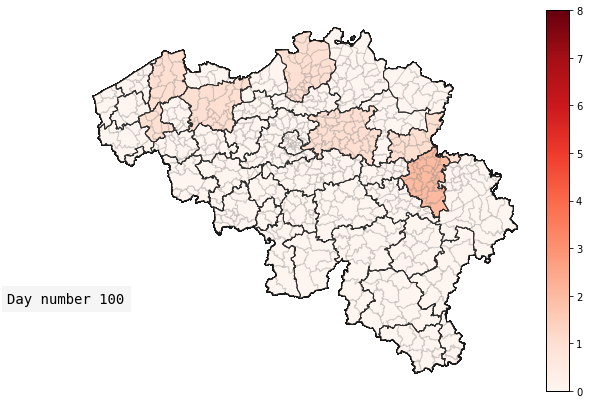

In [74]:
# DISCLAIMER: this is a very computationally demanding process (>1 minute per frame)
# Better to first check whether it will be worth making maps from by simple graphing

start = '2020-03-01'
stop = '2020-06-15'

print('simulating model ...')
out = model.sim(100)
print('start plotting ...')


# Extract list of times and NIS codes
NISlist = out['place'].values
tlist = out['time'].values

# Add column with H_in values and initialise over all NIS codes
arrondissements['H_in'] = 0

# Figure environment
fig, ax = plt.subplots(figsize = (12,7)) # 12 inch x 7 inch
cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
ax.set_axis_off()
vmin = out['H_in'].values.min()
vmax = out['H_in'].values.max()

# Save environment
dirname = './'
dpi = 100


for t in tlist:
    print('Creating map for t = ', t)
    for nis in NISlist:
        # Sum over all ages
        H_in = out['H_in'].sum(dim='Nc').sel(place=nis).values[t]
        arrondissements.loc[arrondissements['NISCode']==str(nis), 'H_in'] = H_in
        
    # Add to figure
    fig = arrondissements.plot(column='H_in', ax=ax, cmap='Reds',
         legend=True, edgecolor = 'k', vmin=vmin, vmax=vmax, cax=cax)
    municipalities.plot(color='none', edgecolor='grey', ax=ax, alpha=0.2)
    
    # Add metadata
    plt.figtext(.15, .30, 'Day number ' + str(t), backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)

    # Save figure
    chart = fig.get_figure()
    figname = 'Spatial-simulation_H-in_20-30yo-21000_' + str(t) + '.jpg'
    chart.savefig(dirname + figname, dpi=dpi, bbox_inches='tight')
    print('Saved figure ' + figname)

In [138]:
# Test where the probability goes over 1 // under 0
spatial = 'prov'
mobility = 1

params = model_parameters.get_COVID19_SEIRD_parameters(age_stratified=True, spatial=spatial)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices(spatial=spatial)

G = params['place'].shape[0] # spatial stratification
N = params['Nc'].shape[0] # age stratification

params['pi'] = np.ones(N) * mobility

l = 1.0 # timestep
n = 1 # number of draws

# If 1e3 is changed to 1e20 we would expect the probability to go to unity, but it does not.
I = 0*np.ones([G,N])
A = 0*np.ones([G,N])
M = np.zeros([G,N])
ER = np.zeros([G,N])
C = np.zeros([G,N])
ICU = np.zeros([G,N])
C_icurec = np.zeros([G,N])
R = np.zeros([G,N])
D = np.zeros([G,N])
S = initN
E = np.ones([G,N])
T = I + A + M + ER + C + ICU + C_icurec + R + D + S + E

# Define hospitalisations
H_in = np.zeros([G,N])
H_out = np.zeros([G,N])
H_tot = np.zeros([G,N])


T_eff = np.zeros([G,N]) # initialise
A_eff = np.zeros([G,N])
I_eff = np.zeros([G,N])
for g in range(G):
    for i in range(N):
        sumT = 0
        sumA = 0
        sumI = 0
        for h in range(G):
            term1 = (1 - params['pi'][i]) * np.identity(G)[h][g]
            term2 = params['pi'][i] * params['place'][h][g]
            sumT += (term1 + term2) * T[h][i]
            sumA += (term1 + term2) * A[h][i]
            sumI += (term1 + term2) * I[h][i]
        T_eff[g][i] = sumT
        A_eff[g][i] = sumA
        I_eff[g][i] = sumI


# Density dependence per patch: f[patch]
xi = 0.01 # km^-2
T_eff_total = T_eff.sum(axis=1)
rho = T_eff_total / params['area']
f = 1 + (1 - np.exp(-xi * rho))

# Normalisation factor per age class: zi[age]
# Population per age class
Ti = T.sum(axis=0)
denom = np.zeros(N)
for h in range(G):
    value = f[h] * T_eff[h]
    denom += value
zi = Ti / denom

# The probability to get infected in the 'home patch' when in a particular age class: P[patch][age]
# initialisation for the summation over all ages below
argument = np.zeros([G,N])
for i in range(N):
    for g in range(G):
        summ = 0
        for j in range(N):
            term = - params['beta'] * params['s'][i] * zi[i] * f[g] * params['Nc'][i,j] * (I_eff[g,j] + A_eff[g,j]) / T_eff[g,j]
            summ += term
        argument[g,i] = summ
P = 1 - np.exp(l * argument) # multiplied by length of timestep

# The probability to get infected in any patch when in a particular age class: Pbis[patch][age]
Pbis = np.zeros([G,N]) # initialise
# THIS NEEDS TO BE CHANGED if PLACE BECOMES AGE-STRATIFIED
for i in range(N):
    for g in range(G):
        summ = 0
        for h in range(G):
            term = params['place'][g,h] * P[h,i]
            summ += term
        Pbis[g,i] = summ

# The total probability bigP[patch][age], depending on mobility parameter pi[age]
bigP = np.zeros([G,N])
for i in range(N):
    for g in range(G):
        bigP[g,i] = (1 - params['pi'][i]) * P[g,i] + params['pi'][i] * Pbis[g,i]


# To be added: effect of average family size (sigma^g or sg)


# Make a dictionary containing the propensities of the system
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

keys = ['StoE','EtoI','ItoA','ItoM','AtoR','MtoR','MtoER','ERtoC','ERtoICU','CtoR','ICUtoCicurec','CicurectoR','CtoD','ICUtoD','RtoS']


# Probabilities for a single agent to migrate between SEIR compartments in one unit of the timestep (typically days)
probabilities = [bigP,
                (1 - np.exp(- l * (1/params['sigma']) ))*np.ones([G,N]),
                1 - np.exp(- l * params['a'] * (1/params['omega']) )*np.ones([G,N]),
                1 - np.exp(- l * (1-params['a'])* (1/params['omega']) )*np.ones([G,N]),
                (1 - np.exp(- l * (1/params['da']) ))*np.ones([G,N]),
                (1 - np.exp(- l * (1-params['h'])* (1/params['dm']) ))*np.ones([G,N]),
                1 - np.exp(- l * params['h'] * (1/params['dhospital']) )*np.ones([G,N]),
                1 - np.exp(- l * params['c'] * (1/params['der']) )*np.ones([G,N]),
                1 - np.exp(- l * (1-params['c']) * (1/params['der']) )*np.ones([G,N]),
                (1 - np.exp(- l * (1-params['m_C']) * (1/params['dc_R']) ))*np.ones([G,N]), ###
                (1 - np.exp(- l * (1-params['m_ICU']) * (1/params['dICU_R']) ))*np.ones([G,N]),
                (1 - np.exp(- l * (1/params['dICUrec']) ))*np.ones([G,N]),
                (1 - np.exp(- l * params['m_C'] * (1/params['dc_D']) ))*np.ones([G,N]),
                (1 - np.exp(- l * params['m_ICU'] * (1/params['dICU_D']) ))*np.ones([G,N]),
                (1 - np.exp(- l * params['zeta'] ))*np.ones([G,N]),
                ]


states = [S, E, I, I, A, M, M, ER, ER, C, ICU, C_icurec, C, ICU, R]
propensity={}
# Calculate propensity for each migration (listed in keys)
for k in range(len(keys)):
    prop=np.zeros([G,N])
    for g in range(G):
        for i in range(N):
            # If state is empty, no one can migrate out of it
            if states[k][g][i]<=0:
                prop[g,i]=0
            else:
                draw=np.array([])
                # Loop over number of draws. Calculate binomial random number per draw and pick average
                for l in range(n):
                    draw = np.append(draw,np.random.binomial(states[k][g][i],probabilities[k][g][i]))
                draw = np.rint(np.mean(draw)) # round to nearest integer
                prop[g,i] = draw
    # Define migration flow
    propensity.update({keys[k]: np.asarray(prop)})


S  = S - propensity['StoE'] + propensity['RtoS']
E  =  E + propensity['StoE'] - propensity['EtoI']
I =  I + propensity['EtoI'] - propensity['ItoA'] - propensity['ItoM']
A =  A + propensity['ItoA'] - propensity['AtoR']
M =  M + propensity['ItoM'] - propensity['MtoR'] - propensity['MtoER']
ER = ER + propensity['MtoER'] - propensity['ERtoC'] - propensity['ERtoICU']
C =  C + propensity['ERtoC'] - propensity['CtoR'] - propensity['CtoD']
C_icurec =  C_icurec + propensity['ICUtoCicurec'] - propensity['CicurectoR']
ICU =  ICU +  propensity['ERtoICU'] - propensity['ICUtoCicurec'] - propensity['ICUtoD']
R =  R + propensity['AtoR'] + propensity['MtoR'] + propensity['CtoR'] + propensity['CicurectoR'] - propensity['RtoS']
D = D +  propensity['ICUtoD'] +  propensity['CtoD']
H_in = propensity['ERtoC'] + propensity['ERtoICU']
H_out = propensity['CtoR'] + propensity['CicurectoR']
H_tot = H_tot + H_in_new - H_out_new - propensity['ICUtoD'] -  propensity['CtoD']


array([[1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [70]:
# Big file -- takes a while
# raw_df = pd.read_excel("../../data/raw/interaction_matrices/demographic/TF_SOC_POP_STRUCT_2020.xlsx")
# -----------------

age_lims = [10,20,30,40,50,60,70,80]
age_names = ["[0, 10)","[10, 20)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 110)","total"]



NIS_list_df = pd.read_csv("../../data/interim/census_2011/census-2011-updated_row-commutes-to-column_prov.csv")
NIS_list = NIS_list_df['NIS'].sort_index().values


initN_prov = np.zeros([len(NIS_list), len(age_lims) + 2], dtype=int)
for g in range(len(NIS_list)):
    nis = NIS_list[g]
    region = raw_df[raw_df['CD_PROV_REFNIS']==nis]
    for i in range(len(age_lims)):
        age = age_lims[i]
        region_age = region[(region['CD_AGE'] < age) & (region['CD_AGE'] >= age - 10)]
        pop = region_age['MS_POPULATION'].sum(axis=0)
        initN_prov[g,i] = pop
    region_old = region[(region['CD_AGE'] >= 80)]
    pop = region_old['MS_POPULATION'].sum(axis=0)
    initN_prov[g,-2] = pop
    initN_prov[g,-1] = initN_prov[g,:-1].sum()
    if nis == 21000:
        region = raw_df[raw_df['CD_DSTR_REFNIS']==nis]
        for i in range(len(age_lims)):
            age = age_lims[i]
            region_age = region[(region['CD_AGE'] < age) & (region['CD_AGE'] >= age - 10)]
            pop = region_age['MS_POPULATION'].sum(axis=0)
            initN_prov[g,i] = pop
        region_old = region[(region['CD_AGE'] >= 80)]
        pop = region_old['MS_POPULATION'].sum(axis=0)
        initN_prov[g,-2] = pop
        initN_prov[g,-1] = initN_prov[g,:-1].sum()
    
initN_prov_df = pd.DataFrame(initN_prov, columns=age_names, index=NIS_list)
initN_prov_df.index.name = 'NIS'

initN_prov_df.sum()

# initN_prov_df.to_csv("initN_prov.csv")

[0, 10)       1269068
[10, 20)      1300254
[20, 30)      1407645
[30, 40)      1492290
[40, 50)      1504539
[50, 60)      1590628
[60, 70)      1347139
[70, 80)       924291
[80, 110)      656787
total        11492641
dtype: int64